In [18]:
import numpy as np
import pandas as pd
import os
import gc
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Bidirectional, Input, LSTM, RNN, concatenate
from tensorflow.keras.layers import Embedding, Dropout, Activation, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import codecs
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('jigsaw_train.csv')
test = pd.read_csv('jigsaw_test.csv')
sample = pd.read_csv('jigsaw_sample.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
glove_embedding_file = 'C:\\Users\\Sai Shiva Ganesan\\Downloads\\glove.840B.300d\\glove.840B.300d.txt'
fast_embedding_file = 'C:\\Users\\Sai Shiva Ganesan\\Downloads\\crawl-300d-2M.vec\\crawl-300d-2M.vec'

In [5]:
train['comment_text'] = train['comment_text'].apply(lambda x: x.replace('\n', ' '))
test['comment_text'] = test['comment_text'].apply(lambda x: x.replace('\n', ' '))
train_sentences = train['comment_text'].fillna("na").values
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[classes].values
test_sentences = test['comment_text'].str.lower().fillna("na").values

Tokenizing both train and text sentences.

In [6]:
num_words = 20000
max_len = 100
embed_size = 300

In [7]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(train_sentences))
train_tokenized = tokenizer.texts_to_sequences(train_sentences)
test_tokenized = tokenizer.texts_to_sequences(test_sentences)

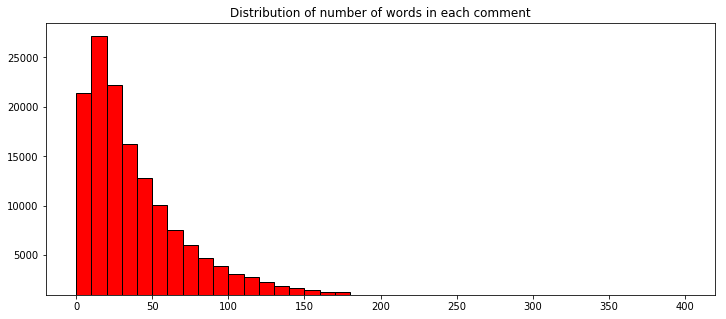

In [8]:
#Checking distribution of sentence length in training comments
words_dist= []

for comment in train_tokenized:
    length = len(comment)
    words_dist.append(length)
    
plt.figure(figsize=(12,5))
plt.hist(words_dist, bins = np.arange(0, 410, 10), color='r', edgecolor='k')
plt.ylim(1000)
plt.title('Distribution of number of words in each comment')
plt.show()

Most of the sentences have a word length of 20-30. With a few being at a maximum range of 150-200. Hence setting the max length to 100.

Padding sentences to have uniform length.

In [9]:
train_padded = pad_sequences(train_tokenized, maxlen=max_len, padding = 'pre')
test_padded = pad_sequences(test_tokenized, maxlen=max_len, padding= 'pre')

Reading glove vectors.

In [10]:
glove_embeddings_index = {}
f = codecs.open(glove_embedding_file, encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

2196018it [06:40, 5485.41it/s]


In [11]:
def coefs(word, *arr):
    return word, np.asarray(arr)

fast_embeddings_index = dict(coefs(*o.strip().split()) for o in open(fast_embedding_file, encoding='utf8'))

Using the std mean and std dev of glove embeddings to randomly initialize words that are not present in GloVe.

In [146]:
# embeddings_stacked = np.stack(glove_embeddings.values())
# emb_mean, emb_std = embeddings_stacked.mean(), embeddings_stacked.std()
# emb_mean, emb_std

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.020940498, 0.6441043)

In [12]:
word_index = tokenizer.word_index
#min(num_words, len(word_index))
glove_embeddings_matrix = np.zeros((num_words, embed_size))

for word, i in tqdm(word_index.items()):
    if i>=num_words:
        continue
    glove_embedding_vector = glove_embeddings_index.get(word)
    if glove_embedding_vector is not None:
        glove_embeddings_matrix[i] = glove_embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 210337/210337 [02:27<00:00, 1430.03it/s]


In [13]:
glove_embeddings_matrix.shape

(20000, 300)

In [14]:
word_index = tokenizer.word_index
#min(num_words, len(word_index))
fast_embeddings_matrix = np.zeros((num_words, embed_size))

for word, i in tqdm(word_index.items()):
    if i>=num_words:
        continue
    fast_embedding_vector = fast_embeddings_index.get(word)
    if fast_embedding_vector is not None:
        fast_embeddings_matrix[i] = fast_embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 210337/210337 [02:38<00:00, 1323.22it/s]


In [15]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

Meta Features

In [148]:
# #Number of words in each comment
# train['words_count'] = train['comment_text'].apply(lambda x: len(str(x).split()))
# test['words_count'] = test['comment_text'].apply(lambda x: len(str(x).split()))

# #Number of unique words in each comment
# train['unique_words_count'] = train['comment_text'].apply(lambda x: len(set(str(x).split())))
# test['unique_words_count'] = test['comment_text'].apply(lambda x: len(set(str(x).split())))

# #Number of characters in each comment
# train['char_count'] = train['comment_text'].apply(lambda x: len(str(x)))
# test['char_count'] = test['comment_text'].apply(lambda x: len(str(x)))

# #Number of stop words in each comment
# stopwords = set(stopwords.words('english'))
# train['stopwords_count'] = train['comment_text'].apply(lambda x: len([y for y in str(x).lower().split() if y in stopwords]))
# test['stopwords_count'] = test['comment_text'].apply(lambda x: len([y for y in str(x).lower().split() if y in stopwords]))

# #Number of punctuations in each comment
# train['puncuation_count'] = train['comment_text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))
# test['puncuation_count'] = test['comment_text'].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))

# #Number of upper case words in each comment
# train['uppercase_count'] = train['comment_text'].apply(lambda x: len([u for u in str(x).split() if u.isupper()]))
# test['uppercase_count'] = train['comment_text'].apply(lambda x: len([u for u in str(x).split() if u.isupper()]))

# #Number of title case words in each comment
# train['titlecase_count'] = train['comment_text'].apply(lambda x: len([t for t in str(x).split() if t.istitle()]))
# test['titlecase_count'] = train['comment_text'].apply(lambda x: len([t for t in str(x).split() if t.istitle()]))

# #Average length of words in comment
# train['avg_word_len'] = train['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# test['avg_word_len'] = test['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [149]:
# cols = ['words_count', 'unique_words_count', 'char_count', 'stopwords_count', 'puncuation_count', 'uppercase_count',
#        'titlecase_count', 'avg_word_len']
# train_meta = train[cols]
# test_meta = test[cols]

Setting up the functional deep neural network model

In [30]:
embeds = Input(shape=(max_len, ))
embed_glove = Embedding(num_words, embed_size, weights= [glove_embeddings_matrix], trainable=False)(embeds)
embed_fast = Embedding(num_words, embed_size, weights= [fast_embeddings_matrix], trainable=False)(embeds)
conc = concatenate([embed_glove, embed_fast])
x = Bidirectional(LSTM(60, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(conc)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)
model = Model(inputs = embeds, outputs = x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 300)     6000000     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 300)     6000000     input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 100, 600)     0           embedding_10[0][0]               
                                                                 embedding_11[0][0]         

Fitting the model with train data

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, y, train_size=0.95, random_state=503)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

In [26]:
history = model.fit(train_padded, y, batch_size=32, epochs=2, validation_data=(X_val,y_val), callbacks=[RocAuc], verbose=2)

Train on 159571 samples, validate on 7979 samples
Epoch 1/2

 ROC-AUC - epoch: 1 - score: 0.958037 

159571/159571 - 2928s - loss: 0.0836 - accuracy: 0.9744 - val_loss: 0.0594 - val_accuracy: 0.9802
Epoch 2/2

 ROC-AUC - epoch: 2 - score: 0.969536 

159571/159571 - 2564s - loss: 0.0600 - accuracy: 0.9801 - val_loss: 0.0535 - val_accuracy: 0.9817


In [32]:
y_test = model.predict(test_padded, batch_size=1024, verbose=1)

153164/153164 [==============================] - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - E

In [32]:
sample[classes] = y_test
sample.to_csv('jigsaw_.csv', index=False)